# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [2]:
dset.svhn

<module 'torchvision.datasets.svhn' from 'D:\\Programms\\PyCharm 2022.3.1\\saves\\edu_project\\venv\\Lib\\site-packages\\torchvision\\datasets\\svhn.py'>

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# First, lets load the dataset
data_train = dset.SVHN('../data', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ])
                      )
data_test = dset.SVHN('../data/', split='test',
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [15]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = 0.2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [16]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [17]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)
nn_model.to(device)
# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [20]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1}--------------------------")
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            X_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(X_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, dim=1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y_gpu.shape[0]
            loss_accum += loss_value
            if i_step % 100 == 0:
                print(f"loss: {loss_value.item():>6f}")

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct, num_samples = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X_gpu = X.to(device)
            y_gpu = y.to(device)
            pred = model(X_gpu)
            correct += (pred.argmax(1) == y_gpu).type(torch.float).sum().item()
            num_samples += y.shape[0]
    return correct / num_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Epoch: 1--------------------------
loss: 1.495749
loss: 1.528377
loss: 1.451143
loss: 1.450803
loss: 1.274078
loss: 1.566425
loss: 1.452964
loss: 1.358425
loss: 1.402466
loss: 1.368928
Average loss: 1.455823, Train accuracy: 0.580538, Val accuracy: 0.598935
Epoch: 2--------------------------
loss: 1.341132
loss: 1.428618
loss: 1.469063
loss: 1.491844
loss: 1.446388
loss: 1.296647
loss: 1.302811
loss: 1.451218
loss: 1.491337
loss: 1.277240
Average loss: 1.382504, Train accuracy: 0.617462, Val accuracy: 0.623780
Epoch: 3--------------------------
loss: 1.325248
loss: 1.383129
loss: 1.280535
loss: 1.347519
loss: 1.406446
loss: 1.132305
loss: 1.434267
loss: 1.304979
loss: 1.335005
loss: 1.256353
Average loss: 1.353786, Train accuracy: 0.629492, Val accuracy: 0.635247


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [22]:
# Since it's so easy to add layers, let's add some!

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
)
nn_model.type(torch.FloatTensor)
nn_model.to(device)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch: 1--------------------------
loss: 2.313483
loss: 2.242711
loss: 2.177974
loss: 2.130774
loss: 2.149737
loss: 2.173598
loss: 2.087034
loss: 2.202718
loss: 2.136619
loss: 2.133194
Average loss: 2.163470, Train accuracy: 0.200184, Val accuracy: 0.227015
Epoch: 2--------------------------
loss: 2.031282
loss: 2.164778
loss: 1.847063
loss: 1.912472
loss: 1.989381
loss: 1.887518
loss: 1.957030
loss: 1.876916
loss: 1.836596
loss: 1.815261
Average loss: 1.960807, Train accuracy: 0.307579, Val accuracy: 0.377858
Epoch: 3--------------------------
loss: 1.812780
loss: 1.803784
loss: 1.747755
loss: 1.702169
loss: 1.821187
loss: 1.894261
loss: 1.728911
loss: 1.790551
loss: 1.815218
loss: 1.748543
Average loss: 1.759312, Train accuracy: 0.398799, Val accuracy: 0.418948
Epoch: 4--------------------------
loss: 1.717200
loss: 1.712033
loss: 1.666245
loss: 1.672893
loss: 1.566105
loss: 1.698939
loss: 1.706649
loss: 1.686378
loss: 1.761758
loss: 1.663705
Average loss: 1.695039, Train accuracy: 0

Добавьте слой с Batch Normalization

In [24]:
# We heard batch normalization is powerful, let's use it!
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
)
nn_model.to(device)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch: 1--------------------------
loss: 2.388041
loss: 2.222767
loss: 2.186099
loss: 2.041954
loss: 2.066995
loss: 2.013309
loss: 1.913759
loss: 1.968208
loss: 2.015345
loss: 1.842056
Average loss: 2.038691, Train accuracy: 0.325496, Val accuracy: 0.442768
Epoch: 2--------------------------
loss: 1.968805
loss: 1.808812
loss: 1.775414
loss: 1.777208
loss: 1.840878
loss: 1.663761
loss: 1.728005
loss: 1.729268
loss: 1.644467
loss: 1.750867
Average loss: 1.750793, Train accuracy: 0.478108, Val accuracy: 0.534298
Epoch: 3--------------------------
loss: 1.803219
loss: 1.663228
loss: 1.459245
loss: 1.595146
loss: 1.639187
loss: 1.603579
loss: 1.561590
loss: 1.520043
loss: 1.546957
loss: 1.370842
Average loss: 1.614199, Train accuracy: 0.544569, Val accuracy: 0.580916
Epoch: 4--------------------------
loss: 1.595337
loss: 1.644557
loss: 1.527254
loss: 1.539711
loss: 1.586068
loss: 1.550481
loss: 1.484835
loss: 1.592562
loss: 1.629816
loss: 1.432748
Average loss: 1.528971, Train accuracy: 0

Добавьте уменьшение скорости обучения по ходу тренировки.

In [27]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1}--------------------------")
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            X_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(X_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, dim=1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            loss_accum += loss_value
            if i_step % 100 == 0:
                print(f"loss: {loss_value.item():>6f}")

        scheduler.step()
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        scheduler.step()

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f, LR: %f" % (ave_loss, train_accuracy, val_accuracy, scheduler.get_last_lr()[0]))

    return loss_history, train_history, val_history

In [28]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
)
nn_model.to(device)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 5)

Epoch: 1--------------------------
loss: 2.392375
loss: 2.295559
loss: 2.132676
loss: 2.099469
loss: 1.962183
loss: 1.976278
loss: 1.916898
loss: 1.822216
loss: 1.918698
loss: 1.797657
Average loss: 2.051681, Train accuracy: 0.311521, Val accuracy: 0.411166, LR: 0.000500
Epoch: 2--------------------------
loss: 1.932289
loss: 1.892261
loss: 1.918213
loss: 2.005912
loss: 1.739797
loss: 1.877251
loss: 1.854032
loss: 1.771026
loss: 1.817120
loss: 1.732346
Average loss: 1.808537, Train accuracy: 0.440416, Val accuracy: 0.476486, LR: 0.000250
Epoch: 3--------------------------
loss: 1.960156
loss: 1.768534
loss: 1.761720
loss: 1.726004
loss: 1.760915
loss: 1.669252
loss: 1.686401
loss: 1.680554
loss: 1.613689
loss: 1.671497
Average loss: 1.737776, Train accuracy: 0.481265, Val accuracy: 0.494028, LR: 0.000125
Epoch: 4--------------------------
loss: 1.734766
loss: 1.752694
loss: 1.749094
loss: 1.711439
loss: 1.580202
loss: 1.669371
loss: 1.733988
loss: 1.766384
loss: 1.704131
loss: 1.601035

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [32]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.to("cpu")
    model.eval() # Evaluation mode
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=sampler)
    predictions = []
    ground_truth = []
    for (x, y) in loader:
        prediction = model(x)
        predictions.extend(torch.argmax(prediction, 1).numpy())
        ground_truth.extend(y.numpy())

    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

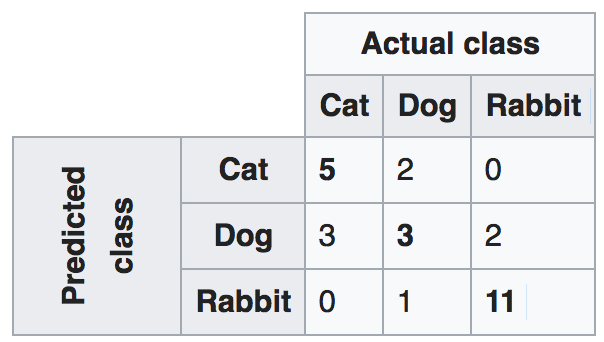

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

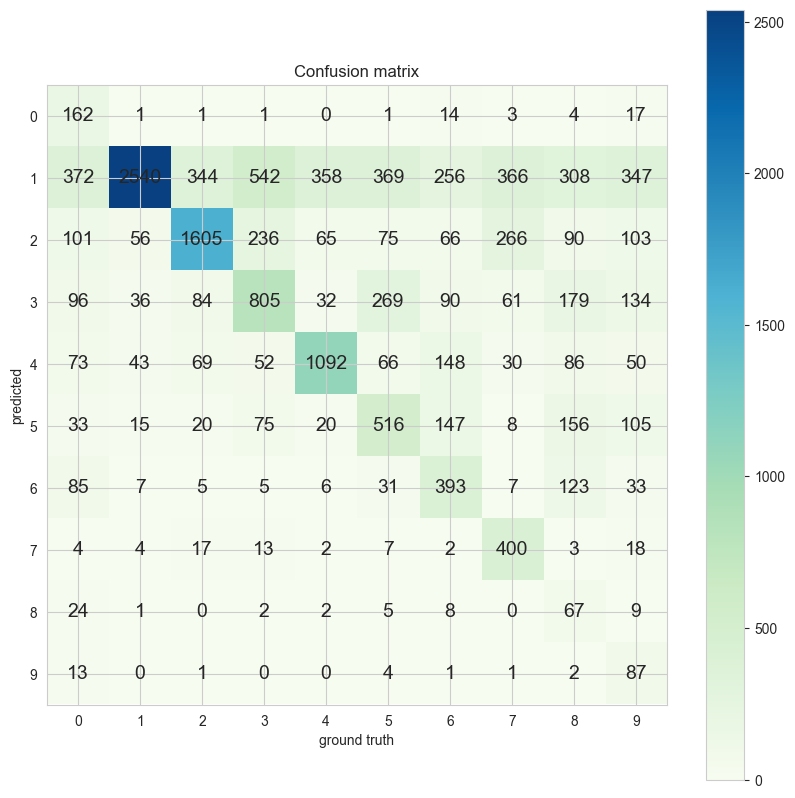

In [33]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    num_classes = len(np.unique(ground_truth))
    confusion_matrix = np.zeros((10,10), int)
    for i in range(num_classes):
        for j in range(num_classes):
            confusion_matrix[i, j] = np.sum(predictions[ground_truth == j] == i)
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

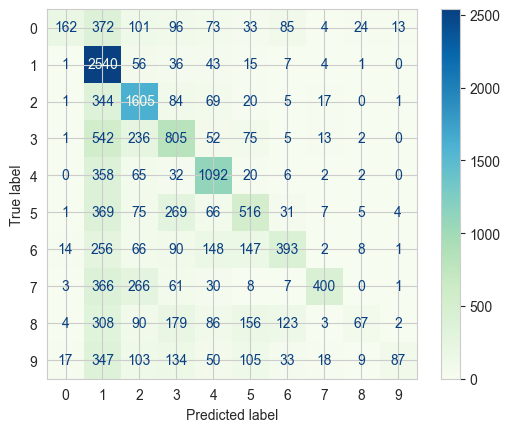

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(gt, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='GnBu')

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

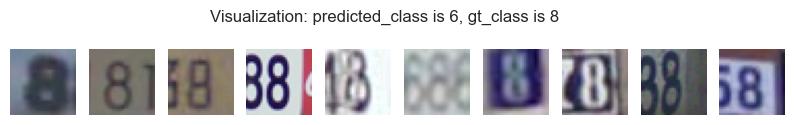

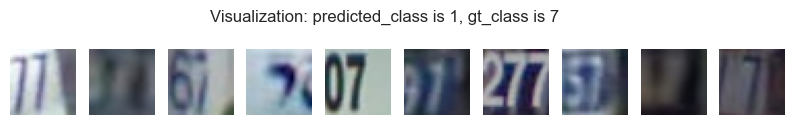

In [35]:
data_train_images = dset.SVHN('../data', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """


    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    title = f'Visualization: predicted_class is {predicted_class}, gt_class is {gt_class}'
    indices_to_visualize = val_indices[(predictions == predicted_class) & (groud_truth == gt_class)]
    visualize_images(indices_to_visualize, data, title)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [ ]:
# Experiment here!

In [37]:
# Как всегда, в конце проверяем на test set
nn_model.to(device)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.5119


## Пишем нормально

In [38]:
class Neural_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.lin_model_stack = nn.Sequential(
                nn.Linear(3*32*32, 100),
                nn.BatchNorm1d(100),
                nn.ReLU(inplace=True),
                nn.Linear(100, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(inplace=True),
                nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        pred = self.lin_model_stack(x)
        return pred

In [44]:
def train_loop(dataloader, model, loss_fn, optimizer, silent=False):
    size = len(dataloader.dataset)
    correct, total_samples = 0, 0
    # Переводим модель в режим тренировки, это важно при использовании batch normalization и dropout layers
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Предсказание и лосс
        pred = model(X)
        loss = loss_fn(pred, y)

        # Обратный ход
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        total_samples += y.shape[0]
        if batch % 100 == 0 and not silent:
            loss, accuracy, current = loss.item(), correct / total_samples, batch * batch_size + len(X)
            print(f"loss: {loss:>7f} | accuracy: {accuracy:>6f}  [{current:>5d}/{size:>5d}], LR: {optimizer.param_groups[0]['lr']}")
    return correct / total_samples

def test_loop(dataloader, model, loss_fn, silent=False):
    # Переводим модель в режим вычислений
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss,  correct = 0, 0
    num_samples = 0
    # Вычисляем с torch.no_grad(), чтобы лишний раз не вычислять градиенты у тензоров
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            num_samples += y.shape[0]
    test_loss /= num_batches
    correct /= num_samples
    if not silent:
        print(f"\nTest Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100 * correct

In [45]:
data_train = dset.SVHN('../data', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ])
                      )
data_test = dset.SVHN('../data/', split='test',
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ]))

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [47]:
model = Neural_Net().to(device)

In [48]:
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [49]:
%%time
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss, optimizer)
    test_loop(val_loader, model, loss)
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
loss: 2.501495 | accuracy: 0.062500  [   64/73257], LR: 0.001
loss: 2.197336 | accuracy: 0.128249  [ 6464/73257], LR: 0.001
loss: 2.167520 | accuracy: 0.171098  [12864/73257], LR: 0.001
loss: 2.153271 | accuracy: 0.201879  [19264/73257], LR: 0.001
loss: 1.961935 | accuracy: 0.225335  [25664/73257], LR: 0.001
loss: 2.149055 | accuracy: 0.246445  [32064/73257], LR: 0.001
loss: 1.905001 | accuracy: 0.267471  [38464/73257], LR: 0.001
loss: 1.729330 | accuracy: 0.284772  [44864/73257], LR: 0.001
loss: 1.802159 | accuracy: 0.300542  [51264/73257], LR: 0.001
loss: 1.777135 | accuracy: 0.315413  [57664/73257], LR: 0.001

Test Error: 
 Accuracy: 45.6%, Avg loss: 1.784018 

Epoch 2
-------------------------------
loss: 1.850682 | accuracy: 0.437500  [   64/73257], LR: 0.001
loss: 1.893764 | accuracy: 0.452970  [ 6464/73257], LR: 0.001
loss: 1.727116 | accuracy: 0.460354  [12864/73257], LR: 0.001
loss: 1.714818 | accuracy: 0.467764  [19264/73257], LR: 0.001

Тюним гиперпараметры

In [40]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

space = {
    "optim": hp.choice("optim", ["sgd", "adam"]),
    # "sch" : hp.choice("sch", ["step_lr", "none"]),
    "lr" : hp.uniform("lr", 0.0001, 0.001),
    "wd" : hp.uniform("wd", 0.0001, 0.01)
}

def score(params):
    print("Params:", params)
    model = Neural_Net().to(device)
    optims = {
        "sgd"  : optim.SGD(model.parameters(), lr=params["lr"], weight_decay=params["wd"]),
        "adam" : optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["wd"])
    }
    optimizer = optims[params["optim"]]
    # schedulers = {
    #     'step_lr': optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5),
    #     'none': None
    # }
    # scheduler = schedulers[params["sch"]]
    epochs = 10
    val_scores = []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss, optimizer, silent=True)
        val_scores.append(test_loop(val_loader, model, loss, silent=False))
        # if scheduler is not None:
        #     scheduler.step()

    score = val_scores[-1]
    print(f"Score: {score}")
    return {"loss": -score, "status": STATUS_OK}

def optimize(trials, space, max_evals=10):
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
    return best

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trials = Trials()
best_params = optimize(trials, space, 5)

Params:                                              
{'lr': 0.0005700943431937656, 'optim': 'sgd', 'wd': 0.008341876898670615}
Epoch 1                                              
-------------------------------
                                                     
Test Error: 
 Accuracy: 38.7%, Avg loss: 1.933578 

Epoch 2                                              
-------------------------------
                                                     
Test Error: 
 Accuracy: 48.5%, Avg loss: 1.725686 

Epoch 3                                              
-------------------------------
                                                     
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.584143 

Epoch 4                                              
-------------------------------
                                                     
Test Error: 
 Accuracy: 59.2%, Avg loss: 1.471145 

Epoch 5                                              
-------------------------------
                  

In [50]:
{'lr': 0.0008801766592410029, 'optim': 1, 'wd': 0.00171639347613525}

{'lr': 0.0008801766592410029, 'optim': 1, 'wd': 0.00171639347613525}

In [52]:
# best_params

In [24]:
%%time
model = Neural_Net().to(device)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=0.0008801766592410029, weight_decay=0.00171639347613525)
train_results = []
test_results = []
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_results.append(train_loop(train_loader, model, loss, optimizer))
    test_results.append(test_loop(val_loader, model, loss))
print("Done!")

Epoch 1
-------------------------------
loss: 2.356873 | accuracy: 0.140625  [   64/73257], LR: 0.0008801766592410029
loss: 1.670002 | accuracy: 0.294709  [ 6464/73257], LR: 0.0008801766592410029
loss: 1.314935 | accuracy: 0.395678  [12864/73257], LR: 0.0008801766592410029
loss: 1.378224 | accuracy: 0.452762  [19264/73257], LR: 0.0008801766592410029
loss: 1.438704 | accuracy: 0.493999  [25664/73257], LR: 0.0008801766592410029
loss: 0.918378 | accuracy: 0.519368  [32064/73257], LR: 0.0008801766592410029
loss: 1.349727 | accuracy: 0.538400  [38464/73257], LR: 0.0008801766592410029
loss: 1.102826 | accuracy: 0.556303  [44864/73257], LR: 0.0008801766592410029
loss: 0.933583 | accuracy: 0.568976  [51264/73257], LR: 0.0008801766592410029
loss: 0.893678 | accuracy: 0.579634  [57664/73257], LR: 0.0008801766592410029

Test Error: 
 Accuracy: 68.1%, Avg loss: 1.023702 

Epoch 2
-------------------------------
loss: 1.194185 | accuracy: 0.609375  [   64/73257], LR: 0.0008801766592410029
loss: 1.0

In [25]:
print(train_results)
print(test_results)

[0.5806572705866293, 0.6965498413131761, 0.7256765518888851, 0.7398389243422175, 0.7464764699860083, 0.7513223901989557, 0.7556564174316623, 0.7601610756577825, 0.7621233320820394, 0.7617138176978466, 0.7655530150496537, 0.7657407091424087, 0.7641538409036618, 0.767907722758762, 0.7644268504931235, 0.7653141316588745, 0.7652800054601918, 0.7680954168515169, 0.7704159983619424, 0.7695287171961915]
[68.07043887789229, 72.6912838714081, 73.46938775510205, 76.44529383659818, 76.14497303938298, 76.3975155279503, 76.48624667258208, 77.18927035697222, 76.58180328987783, 79.13453006620709, 78.28134598320933, 78.15166200259368, 77.16879393898027, 78.6703979250563, 78.61579414374445, 78.43833185448092, 78.54071394444065, 80.03549245785271, 77.27800150160398, 77.11419015766842]


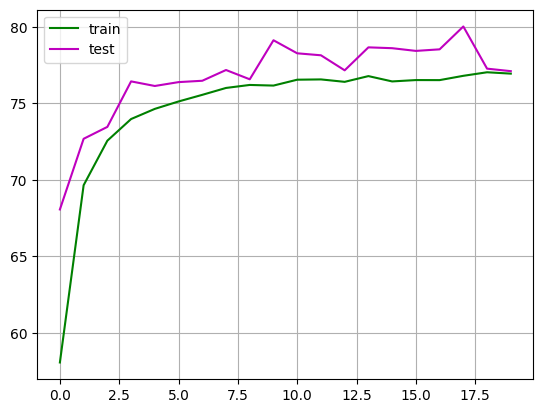

In [26]:
x = np.arange(0, 20)
plt.plot(x,  np.array(train_results) * 100, c="green", label="train")
plt.plot(x, test_results, c="m", label="test")
plt.legend()
plt.grid()

In [32]:
test_loader.dataset

(26032, 3, 32, 32)

In [92]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64)
model.to("cpu")
pred_id = []
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        pred = model(X)
        pred_id.extend(pred.argmax(1))

In [93]:
pred_id = [elem.item() for elem in pred_id]
pred_id

[5,
 2,
 1,
 0,
 1,
 1,
 5,
 1,
 1,
 8,
 9,
 6,
 5,
 1,
 4,
 4,
 1,
 1,
 3,
 4,
 2,
 0,
 1,
 9,
 2,
 5,
 8,
 1,
 4,
 3,
 9,
 3,
 6,
 6,
 0,
 1,
 5,
 1,
 3,
 2,
 3,
 1,
 6,
 5,
 2,
 8,
 1,
 2,
 0,
 6,
 9,
 1,
 5,
 1,
 9,
 6,
 4,
 5,
 1,
 9,
 2,
 0,
 2,
 8,
 3,
 3,
 6,
 9,
 3,
 2,
 3,
 5,
 1,
 1,
 4,
 6,
 2,
 4,
 3,
 1,
 4,
 1,
 7,
 1,
 2,
 1,
 7,
 1,
 0,
 1,
 1,
 4,
 6,
 4,
 1,
 2,
 2,
 1,
 7,
 7,
 4,
 8,
 2,
 7,
 6,
 2,
 3,
 1,
 8,
 6,
 3,
 2,
 6,
 4,
 3,
 7,
 2,
 6,
 0,
 2,
 8,
 8,
 1,
 7,
 3,
 1,
 1,
 4,
 2,
 0,
 6,
 3,
 7,
 3,
 8,
 2,
 0,
 3,
 0,
 1,
 7,
 2,
 4,
 6,
 7,
 2,
 1,
 3,
 9,
 7,
 1,
 5,
 9,
 1,
 8,
 3,
 3,
 6,
 1,
 6,
 4,
 9,
 3,
 6,
 1,
 6,
 1,
 2,
 6,
 2,
 7,
 5,
 2,
 2,
 1,
 4,
 6,
 9,
 6,
 7,
 1,
 0,
 2,
 5,
 4,
 8,
 3,
 2,
 1,
 6,
 2,
 6,
 1,
 7,
 7,
 3,
 6,
 1,
 1,
 3,
 7,
 2,
 2,
 5,
 6,
 2,
 1,
 0,
 4,
 7,
 1,
 0,
 2,
 3,
 7,
 3,
 1,
 1,
 1,
 2,
 0,
 2,
 7,
 2,
 1,
 2,
 6,
 2,
 2,
 9,
 2,
 5,
 7,
 4,
 1,
 4,
 9,
 4,
 3,
 2,
 7,
 4,
 0,
 5,
 1,
 7,
 1,
 0,
 3,
 6,


In [95]:
from sklearn.metrics import accuracy_score

accuracy_score(test_loader.dataset.labels, pred_id)

0.7448524892440074

In [72]:
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct, num_samples = 0, 0
    with torch.no_grad():
        for X, y in loader:
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            num_samples += y.shape[0]
    return correct / num_samples

In [99]:
# Как всегда, в конце проверяем на test set
model.to("cpu")
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7342


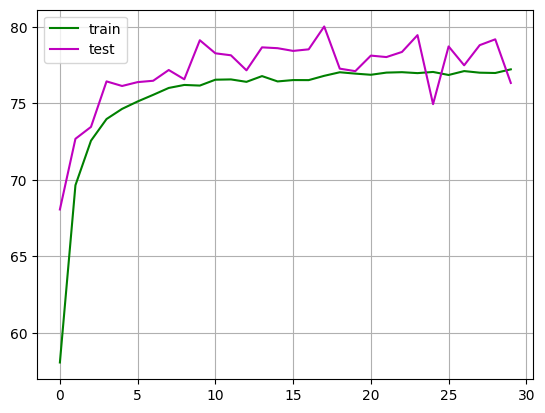

In [98]:
x = np.arange(0, 30)
plt.plot(x,  np.array(train_results) * 100, c="green", label="train")
plt.plot(x, test_results, c="m", label="test")
plt.legend()
plt.grid()

In [101]:
torch.save(model, "first_assignment_model.pth")